# Import Stuff

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from pyproj import Proj, Transformer
from gmsys_reader import *

# Read the Model Files

First we load the model's block file (.blk), coordinate system (.ecs), body geometry (.sur), gravity data (.grv), and magnetic data (.mag).

In [2]:
model_main_name = r'rangi_residual_grav_2x5D_2x5KM_WE_B3'
blk_filename = model_main_name+'.blk'
model_properties = parse_blk_file(blk_filename)
model_coordinate = parse_ecs_file(model_main_name+'.ecs')
model_geom = parse_sur_file(model_main_name+'.sur')
model_gravData = grav_file_reader(model_main_name+'.grv')
model_magData = mag_file_reader(r'rangi_totalMag_2x5D_WE_C2G.mag')
model_wells = well_file_reader(model_main_name+'.wel')

Change the coordinate system of the model from NZTM to NZMG

In [3]:
model_geom['Geometry_xyz (m)'] = ""
model_projection = model_coordinate[-1]
change_coord = Proj('epsg:27200') 
transform_coord = Transformer.from_proj(model_projection, change_coord, always_xy=True)
for units in model_geom.index:
    xz_loc = np.array(model_geom.loc[units,'Geometry (Xm,Ym)'])
    # Extract x coordinates
    distance_coords = xz_loc[:,0]
    # Calculate corresponding y coordinates using trigonometry
    model_origin_X, model_origin_Y = transform_coord.transform(model_coordinate[0], model_coordinate[1]) #this works
    #model_origin_X, model_origin_Y = model_coordinate[0], model_coordinate[1]
    x_coords = model_origin_X + (distance_coords*np.cos(np.deg2rad(90-model_coordinate[2])))
    y_coords = model_origin_Y + (distance_coords*np.sin(np.deg2rad(90-model_coordinate[2])))
    # Combine x, y, and z coordinates into a single array
    xyz_coord = np.column_stack((x_coords, y_coords, xz_loc[:,1]))
    model_geom.at[units,'Geometry_xyz (m)'] = [vertex.tolist() for vertex in xyz_coord]

View the combined model

In [4]:
combined_model = model_properties.join(model_geom)
combined_model

,Model units,Density (kg/m^3),Inclination (deg),Declination (deg),Magsus (SI),RemMag (A/m),Colour (RGB),"Geometry (Xm,Ym)",Geometry_xyz (m)
Body index,,,,,,,,,
1,Background,0.0,0.0,0.0,0.0,0.0,"(1.0, 1.0, 1.0)","[[7501.76, 1.20107], [7631.1, 14.3107], [7760....","[[2679777.2829241976, 6490208.69691182, 1.2010..."
2,Basalt,410.0,0.0,0.0,0.0,0.0,"(0.5019607843137255, 0.5019607843137255, 0.501...","[[4204.98667126113, -28.8461538461539], [4137....","[[2676595.691469413, 6489344.873899898, -28.84..."
3,scoria,-300.0,0.0,0.0,0.0,0.0,"(1.0, 0.5019607843137255, 1.0)","[[4204.98667126113, -28.8461538461539], [4420....","[[2676595.691469413, 6489344.873899898, -28.84..."
4,Ymt,500.0,0.0,0.0,0.0,0.0,"(0.5019607843137255, 0.0, 1.0)","[[-678.783121231021, -515.0115773863721], [-37...","[[2671882.5496517834, 6488065.224888267, -515...."
5,Qva,145.0,0.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0)","[[3492.2, 153.833], [3362.86, 137.491], [3233....","[[2675907.807967506, 6489158.109003488, 153.83..."
6,Qva,145.0,0.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0)","[[4963.39938478518, -13.451231755348001], [514...","[[2677327.6069418886, 6489543.593766006, -13.4..."
7,Mwe_C#1,-135.0,0.0,0.0,0.0,0.0,"(1.0, 0.5019607843137255, 0.0)","[[3569.375443577, -44.755579581434894], [3225....","[[2675982.2870739894, 6489178.330570902, -44.7..."
8,TJw_C#1,280.0,0.0,0.0,0.0,0.0,"(0.5019607843137255, 1.0, 1.0)","[[-3710.92269882514, -515.0115773863721], [-14...","[[2668956.3462377694, 6487270.741409631, -515...."


Change the coordinate system of the gravity data

In [5]:
model_gravData[0]['Real world X (m)']=""
model_gravData[0]['Real world Y (m)']=""
for idx in model_gravData[0].index:
    #model_origin_X, model_origin_Y = model_coordinate[0], model_coordinate[1]
    x_coords = model_origin_X + (model_gravData[0].loc[idx,'Profile Dist (m)']*np.cos(np.deg2rad(90-model_coordinate[2])))
    y_coords = model_origin_Y + (model_gravData[0].loc[idx,'Profile Dist (m)']*np.sin(np.deg2rad(90-model_coordinate[2])))
    model_gravData[0].loc[idx,'Real world X (m)'] = x_coords
    model_gravData[0].loc[idx,'Real world Y (m)'] = y_coords

model_gravData[0][:10]

,Profile Dist (m),Offset from Profile (m),Elevation (m),Observed (mGal),Modelled (mGal),Real world X (m),Real world Y (m)
0,1482.785958,49.013194,4.068000,-3.702695,-3.58834,2673968.59835,6488631.600834
1,2085.227070,-913.128822,35.424779,-5.009340,-5.16735,2674549.99152,6488789.452905
2,2612.984470,-663.231583,60.824904,-5.466544,-5.44034,2675059.310259,6488927.736293
3,2948.936612,-389.027061,85.471271,-5.732613,-5.65994,2675383.524985,6489015.762724
4,3210.752802,-248.892810,113.505000,-6.687281,-6.55297,2675636.193904,6489084.363998
5,3362.275242,-187.117496,127.787043,-6.436686,-6.59229,2675782.42249,6489124.066021
6,3484.445427,-217.019067,138.118000,-6.678870,-6.35865,2675900.324322,6489156.077144
7,3643.180732,-102.285593,161.705000,-5.267084,-5.31515,2676053.513771,6489197.669088
8,3769.318542,-101.021712,163.320721,-4.460467,-4.31618,2676175.244608,6489230.719811
9,3841.628726,-47.433699,173.974000,-4.417550,-4.50724,2676245.028437,6489249.666579


Change the coordinate system of the magnetic data

In [6]:
model_magData[0]['Real world X (m)']=""
model_magData[0]['Real world Y (m)']=""
for idx in model_magData[0].index:
    #model_origin_X, model_origin_Y = model_coordinate[0], model_coordinate[1]
    x_coords = model_origin_X + (model_magData[0].loc[idx,'Profile Dist (m)']*np.cos(np.deg2rad(90-model_coordinate[2])))
    y_coords = model_origin_Y + (model_magData[0].loc[idx,'Profile Dist (m)']*np.sin(np.deg2rad(90-model_coordinate[2])))
    model_magData[0].loc[idx,'Real world X (m)'] = x_coords
    model_magData[0].loc[idx,'Real world Y (m)'] = y_coords
    
model_magData[0][:10]

,Profile Dist (m),Offset from Profile (m),Elevation (m),Observed (nT),Modelled (nT),Real world X (m),Real world Y (m)
0,131.136,-0.005775,449.474,76.41370,71.15623,2672664.172013,6488277.440502
1,262.279,0.000950,445.686,72.97410,73.67114,2672790.733171,6488311.802689
2,393.415,-0.004605,444.431,74.58200,73.12102,2672917.287573,6488346.163041
3,524.561,-0.007526,443.623,73.37600,69.92820,2673043.851625,6488380.526014
4,655.694,-0.003436,442.574,69.55690,64.34135,2673170.403132,6488414.885581
5,786.840,-0.006357,436.543,63.68480,57.05482,2673296.967185,6488449.248554
6,917.973,-0.002266,432.307,55.29120,47.20668,2673423.518692,6488483.608121
7,1049.110,-0.007822,432.708,41.57130,34.43934,2673550.074059,6488517.968735
8,1180.250,-0.001096,435.288,24.99840,18.92550,2673676.632321,6488552.330136
9,1311.390,-0.006652,434.292,8.69726,0.94681,2673803.190583,6488586.691537


# Plot the Model

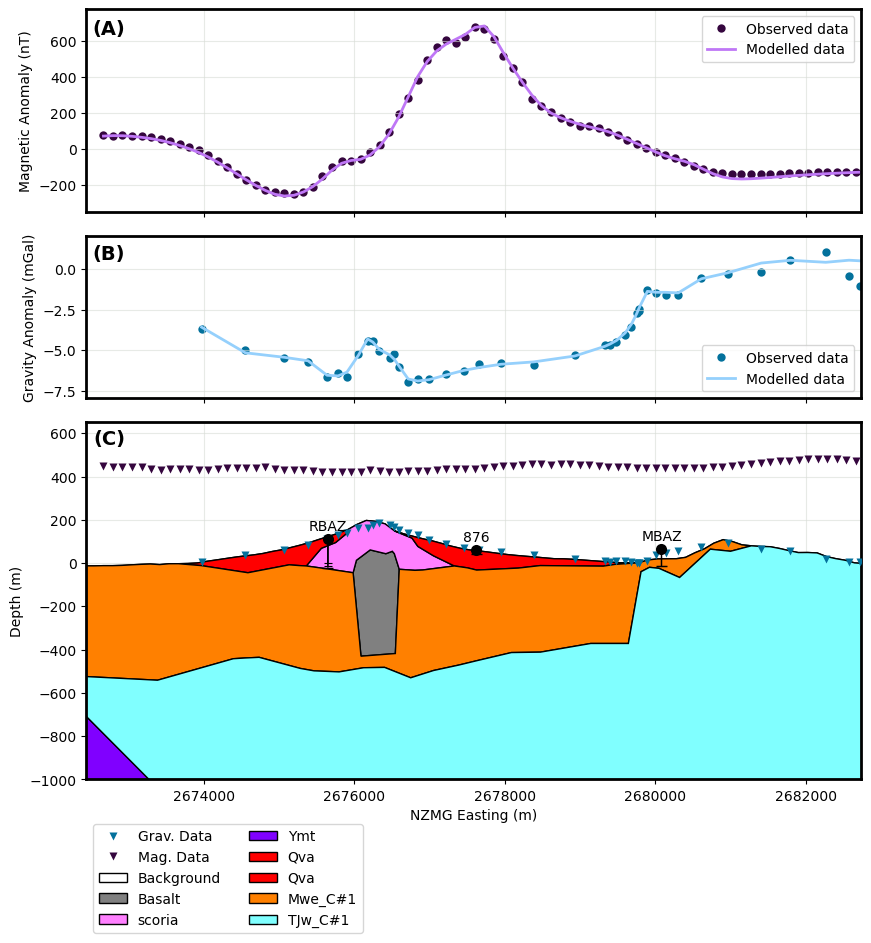

In [7]:
# Create figure and subplots
#### PLOT MAGNETIC DATA ####
fig, axs = plt.subplots(3, 1, figsize=(10,10), height_ratios=[1.25, 1, 2.2], gridspec_kw={'hspace':0.1})

mag_colour = 'purple'
axs[0].plot(model_magData[0]['Real world X (m)'], model_magData[0]['Observed (nT)'], linewidth=0, marker='o', markerfacecolor='xkcd:dark '+mag_colour,
            markeredgecolor='none', zorder=1, label='Observed data')
axs[0].plot(model_magData[0]['Real world X (m)'], model_magData[0]['Modelled (nT)'], linewidth=2, linestyle='-', color='xkcd:light '+mag_colour,
            zorder=2, label='Modelled data')
axs[0].grid(zorder=0, color='xkcd:light gray', alpha=0.6)
axs[0].set_ylim(model_magData[0]['Observed (nT)'].min()-100,model_magData[0]['Observed (nT)'].max()+100)
axs[0].set_ylabel('Magnetic Anomaly (nT)')

#### PLOT GRAVITY DATA ####
grav_colour = 'blue'
axs[1].plot(model_gravData[0]['Real world X (m)'], model_gravData[0]['Observed (mGal)'], linewidth=0, marker='o', markerfacecolor='xkcd:ocean '+grav_colour,
            markeredgecolor='none', zorder=1, label='Observed data')
axs[1].plot(model_gravData[0]['Real world X (m)'], model_gravData[0]['Modelled (mGal)'], linewidth=2, linestyle='-', color='xkcd:light '+grav_colour,
            zorder=2, label='Modelled data')
axs[1].grid(zorder=0, color='xkcd:light gray', alpha=0.6)
axs[1].set_ylim(model_gravData[0]['Observed (mGal)'].min()-1.0,model_gravData[0]['Observed (mGal)'].max()+1.0)
axs[1].set_ylabel('Gravity Anomaly (mGal)')

#### PLOT DATA LOCATIONS ####
axs[2].plot(model_gravData[0]['Real world X (m)'], model_gravData[0]['Elevation (m)'], linewidth=0, marker='v', markerfacecolor='xkcd:ocean '+grav_colour,
            markeredgecolor='none', zorder=3, label='Grav. Data')
axs[2].plot(model_magData[0]['Real world X (m)'], model_magData[0]['Elevation (m)'], linewidth=0, marker='v', markerfacecolor='xkcd:dark '+mag_colour,
            markeredgecolor='none', zorder=3, label='Mag. Data')

#### PLOT THE MODELS ####
for units in model_geom.index:
    vertices = np.array(combined_model.loc[units,'Geometry_xyz (m)'])
    facecolor = combined_model.loc[units,'Colour (RGB)']
    vertices = np.vstack([vertices[:,0],vertices[:,2]]).T
    polygon = Polygon(vertices, closed=True, edgecolor='black', facecolor=facecolor, label=combined_model.loc[units,'Model units'])
    axs[2].add_patch(polygon)
    #axs[2].plot(xy_test[:,0], xy_test[:,2])
    axs[2].set_xlim(model_origin_X+np.array([-100,10200]))
    axs[1].set_xlim(model_origin_X+np.array([-100,10200]))
    axs[0].set_xlim(model_origin_X+np.array([-100,10200]))
    axs[2].set_ylim(-1000,650)
    
#### PLOT THE WELLS ####
for index in model_wells.index:
    well_srf_dist = model_wells.loc[index,'Profile X (m)']
    x_coords = model_origin_X + (well_srf_dist*np.cos(np.deg2rad(90-model_coordinate[2])))
    #y_coords = model_origin_Y + (1e+3*well_srf_dist*np.sin(np.deg2rad(90-model_coordinate[2])))
    well_srf_z0 = model_wells.loc[index,'Elevation (m)']
    units_list = model_wells.at[index,'Units']
    depth_list = model_wells.at[index,'Depths (m)']
    axs[2].text(x_coords, well_srf_z0+25, model_wells.at[index,'Well name'], ha='center', va='bottom', zorder=5)
    axs[2].plot(x_coords, well_srf_z0, marker='o', markersize=8, markerfacecolor='xkcd:black', markeredgecolor='None', zorder=5)
    for idx in range(len(units_list)):
        if idx < len(units_list)-1:
            axs[2].annotate('', xy=(x_coords, depth_list[idx]), xytext=(x_coords, well_srf_z0),
                         arrowprops=dict(arrowstyle='|-|,widthA=0,widthB=0.3', linewidth=0.8, color='xkcd:black', capstyle='butt'),
                         zorder=4)
        elif idx == len(units_list)-1:
            axs[2].annotate('', xy=(x_coords, depth_list[idx]), xytext=(x_coords, well_srf_z0),
                     arrowprops=dict(arrowstyle='|-|,widthA=0,widthB=0.4', linewidth=1.0, color='xkcd:black', capstyle='butt'),
                     zorder=4)

axs[2].set_axisbelow(True)
axs[2].grid(zorder=0, color='xkcd:light gray', alpha=0.6)
axs[2].set_xlabel('NZMG Easting (m)')
axs[2].set_ylabel('Depth (m)')

for direction in ['top', 'bottom', 'left', 'right']:
    # Change the linewidth of the axes spines
    axs[0].spines[direction].set_linewidth(2)
    axs[1].spines[direction].set_linewidth(2)
    axs[2].spines[direction].set_linewidth(2)
    
# Prevent labelling using the scientific notation
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[2].ticklabel_format(useOffset=False, style='plain')

# legend?
axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')
axs[2].legend(loc='lower left',bbox_to_anchor=(0,-0.45),ncols=2)

# Giving the ABC letter
for idx in range(3):
    if idx==2:
        y_text = 0.98
    else:
        y_text = 0.95
    axs[idx].text(0.05, y_text, f"({chr(65 + idx)})", transform=axs[idx].transAxes, ha='right', va='top', fontsize=14, fontweight='bold')